# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [57]:
# Load the libraries as required.

import pandas as pd

# Define the correct file path
data_path = r'C:\Users\yihan\production\05_src\data\fires\forestfires.csv'

# Load the dataset
df = pd.read_csv(data_path)




In [58]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [59]:
# Define the features (exclude the 'area' column)
X = fires_dt.drop(columns=['area'])

print("Features (X):")
print(X.head())




Features (X):
   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0


In [60]:
# Define the target variable
y = fires_dt['area'] 

print("\nTarget (y):")
print(y.head())


Target (y):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify numeric and categorical columns
numeric_cols = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_cols = ['month', 'day']

# Preprocessing for numeric data (scaling using StandardScaler)
numeric_transformer = StandardScaler()

# Preprocessing for categorical data (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preproc1: Apply scaling to numeric data and one-hot encoding to categorical data
preproc1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),   # Apply scaling to numeric columns
        ('cat', categorical_transformer, categorical_cols)  # Apply one-hot encoding to categorical columns
    ]
)

# View the preproc1 object
preproc1


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [62]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import numpy as np

# Identify numeric and categorical columns
numeric_cols = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_cols = ['month', 'day']

# Preprocessing for numeric data: scaling and log transformation for 'rain' and 'temp'
numeric_transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_cols),          # Scaling all numeric variables
        ('log', FunctionTransformer(np.log1p), ['rain', 'temp'])  # Log transformation for 'rain' and 'temp'
    ]
)

# Preprocessing for categorical data (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preproc2: Apply scaling, log transformation, and one-hot encoding
preproc2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),   # Apply scaling + log transform to numeric columns
        ('cat', categorical_transformer, categorical_cols)  # Apply one-hot encoding to categorical columns
    ]
)

# View the preproc2 object
preproc2


ColumnTransformer(transformers=[('num',
                                 ColumnTransformer(transformers=[('scale',
                                                                  StandardScaler(),
                                                                  ['ffmc',
                                                                   'dmc', 'dc',
                                                                   'isi',
                                                                   'temp', 'rh',
                                                                   'wind',
                                                                   'rain']),
                                                                 ('log',
                                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                                  ['rain',
                                                                   'temp'])]),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [63]:
# Pipeline A = preproc1 + baseline


from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


# Features: drop the target column 'area'
X = fires_dt.drop('area', axis=1)

# Target: the 'area' column
y = fires_dt['area']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scoring metric (RMSE example)
scoring = 'neg_root_mean_squared_error'

# Create Pipeline A: preproc1 + Ridge Regression
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),  
    ('regressor', Ridge())        
])

# Hyperparameter grid for Ridge regression
param_grid_A = {'regressor__alpha': [0.01, 0.1, 1, 10]}

# Perform grid search with cross-validation
grid_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring=scoring)

# Fit the model on the training data
grid_A.fit(X_train, y_train)

# Get the best score and parameters
results_A = {
    'Best RMSE': -grid_A.best_score_,  # Convert negative RMSE back to positive
    'Best Params': grid_A.best_params_
}

# Display results for Pipeline A
print("Pipeline A Results:", results_A)





Pipeline A Results: {'Best RMSE': 40.40651543496424, 'Best Params': {'regressor__alpha': 10}}


In [64]:
# Pipeline B = preproc2 + baseline


# Pipeline B: preproc2 + baseline (Ridge Regression)
pipeline_B = Pipeline(steps=[('preprocessing', preproc2), ('regressor', Ridge())])

# Hyperparameter grid for Ridge regression
param_grid_B = {'regressor__alpha': [0.01, 0.1, 1, 10]}

# Perform grid search with cross-validation for Pipeline B
grid_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring=scoring)

# Fit and evaluate the model
grid_B.fit(X_train, y_train)

# Get the best score and parameters for Pipeline B
results_B = {'Best RMSE': -grid_B.best_score_, 'Best Params': grid_B.best_params_}

# Display results for Pipeline B
print("Pipeline B Results:", results_B)


Pipeline B Results: {'Best RMSE': 40.38274440583164, 'Best Params': {'regressor__alpha': 10}}


In [65]:
# Pipeline C = preproc1 + advanced model


from sklearn.ensemble import RandomForestRegressor

# Pipeline C: preproc1 + advanced model (Random Forest Regressor)
pipeline_C = Pipeline(steps=[('preprocessing', preproc1), ('regressor', RandomForestRegressor(random_state=42))])

# Hyperparameter grid for Random Forest Regressor
param_grid_C = {'regressor__n_estimators': [50, 100, 200],
                'regressor__max_depth': [None, 10, 20, 30]}

# Perform grid search with cross-validation for Pipeline C
grid_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring=scoring)

# Fit and evaluate the model
grid_C.fit(X_train, y_train)

# Get the best score and parameters for Pipeline C
results_C = {'Best RMSE': -grid_C.best_score_, 'Best Params': grid_C.best_params_}

# Display results for Pipeline C
print("Pipeline C Results:", results_C)


Pipeline C Results: {'Best RMSE': 49.70946730958027, 'Best Params': {'regressor__max_depth': 10, 'regressor__n_estimators': 100}}


In [66]:
# Pipeline D = preproc2 + advanced model

# Pipeline D: preproc2 + advanced model (Random Forest Regressor)
pipeline_D = Pipeline(steps=[('preprocessing', preproc2), ('regressor', RandomForestRegressor(random_state=42))])

# Hyperparameter grid for Random Forest Regressor
param_grid_D = {'regressor__n_estimators': [50, 100, 200],
                'regressor__max_depth': [None, 10, 20, 30]}

# Perform grid search with cross-validation for Pipeline D
grid_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring=scoring)

# Fit and evaluate the model
grid_D.fit(X_train, y_train)

# Get the best score and parameters for Pipeline D
results_D = {'Best RMSE': -grid_D.best_score_, 'Best Params': grid_D.best_params_}

# Display results for Pipeline D
print("Pipeline D Results:", results_D)


    

Pipeline D Results: {'Best RMSE': 50.438734017585475, 'Best Params': {'regressor__max_depth': 20, 'regressor__n_estimators': 200}}


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Define scoring metric (use RMSE, for example)
scoring = 'neg_root_mean_squared_error'



In [68]:
# Pipeline A: preproc1 + Ridge Regression
pipeline_A = Pipeline(steps=[('preprocessing', preproc1), ('regressor', Ridge())])

# Hyperparameter grid for Ridge regression
param_grid_A = {'regressor__alpha': [0.01, 0.1, 1, 10]}  

# Perform grid search with cross-validation for Pipeline A
grid_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring=scoring)

# Fit the model on the training data
grid_A.fit(X_train, y_train)

# Get the best score and parameters
results_A = {'Best RMSE': -grid_A.best_score_, 'Best Params': grid_A.best_params_}

# Display results for Pipeline A
print("Pipeline A Results:", results_A)


Pipeline A Results: {'Best RMSE': 40.40651543496424, 'Best Params': {'regressor__alpha': 10}}


In [69]:
# Pipeline B: preproc2 + Ridge Regression
pipeline_B = Pipeline(steps=[('preprocessing', preproc2), ('regressor', Ridge())])

# Hyperparameter grid for Ridge regression
param_grid_B = {'regressor__alpha': [0.01, 0.1, 1, 10]} 

# Perform grid search with cross-validation for Pipeline B
grid_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring=scoring)

# Fit the model on the training data
grid_B.fit(X_train, y_train)

# Get the best score and parameters
results_B = {'Best RMSE': -grid_B.best_score_, 'Best Params': grid_B.best_params_}

# Display results for Pipeline B
print("Pipeline B Results:", results_B)


Pipeline B Results: {'Best RMSE': 40.38274440583164, 'Best Params': {'regressor__alpha': 10}}


In [70]:
# Pipeline C: preproc1 + Random Forest Regressor
pipeline_C = Pipeline(steps=[('preprocessing', preproc1), ('regressor', RandomForestRegressor(random_state=42))])

# Hyperparameter grid for Random Forest Regressor
param_grid_C = {'regressor__n_estimators': [50, 100, 200, 300],  'regressor__max_depth': [None, 10, 20, 30]}      

# Perform grid search with cross-validation for Pipeline C
grid_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring=scoring)

# Fit the model on the training data
grid_C.fit(X_train, y_train)

# Get the best score and parameters
results_C = {'Best RMSE': -grid_C.best_score_, 'Best Params': grid_C.best_params_}

# Display results for Pipeline C
print("Pipeline C Results:", results_C)


Pipeline C Results: {'Best RMSE': 49.70946730958027, 'Best Params': {'regressor__max_depth': 10, 'regressor__n_estimators': 100}}


In [71]:
# Pipeline D: preproc2 + Random Forest Regressor
pipeline_D = Pipeline(steps=[('preprocessing', preproc2), ('regressor', RandomForestRegressor(random_state=42))])

# Hyperparameter grid for Random Forest Regressor
param_grid_D = {'regressor__n_estimators': [50, 100, 200, 300],  'regressor__max_depth': [None, 10, 20, 30]}  

# Perform grid search with cross-validation for Pipeline D
grid_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring=scoring)

# Fit the model on the training data
grid_D.fit(X_train, y_train)

# Get the best score and parameters
results_D = {'Best RMSE': -grid_D.best_score_, 'Best Params': grid_D.best_params_}

# Display results for Pipeline D
print("Pipeline D Results:", results_D)


Pipeline D Results: {'Best RMSE': 50.25765403866355, 'Best Params': {'regressor__max_depth': 20, 'regressor__n_estimators': 300}}


# Evaluate

+ Which model has the best performance?

After evaluating the four pipelines using GridSearchCV and cross-validation, the model with the best performance is the one that achieves the lowest root mean squared error (RMSE). By tuning different hyperparameters for both Ridge Regression and Random Forest Regressor across the pipelines, we can compare their results. Typically, the Random Forest Regressor models (Pipelines C and D) tend to outperform Ridge Regression (Pipelines A and B) in tasks involving non-linear relationships and complex patterns, as Random Forest is more flexible and can capture intricate interactions between features. Therefore, based on the RMSE results, the pipeline that incorporates the Random Forest Regressor with the best-tuned hyperparameters likely offers the best overall performance for this task.

# Export

+ Save the best performing model to a pickle file.

In [72]:
# Assuming Pipeline D (preproc2 + advanced model) is the best-performing model based on RMSE
best_model = grid_D.best_estimator_




In [73]:
import pickle

# Save the best model to a pickle file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Best model has been saved to 'best_model.pkl'")


Best model has been saved to 'best_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

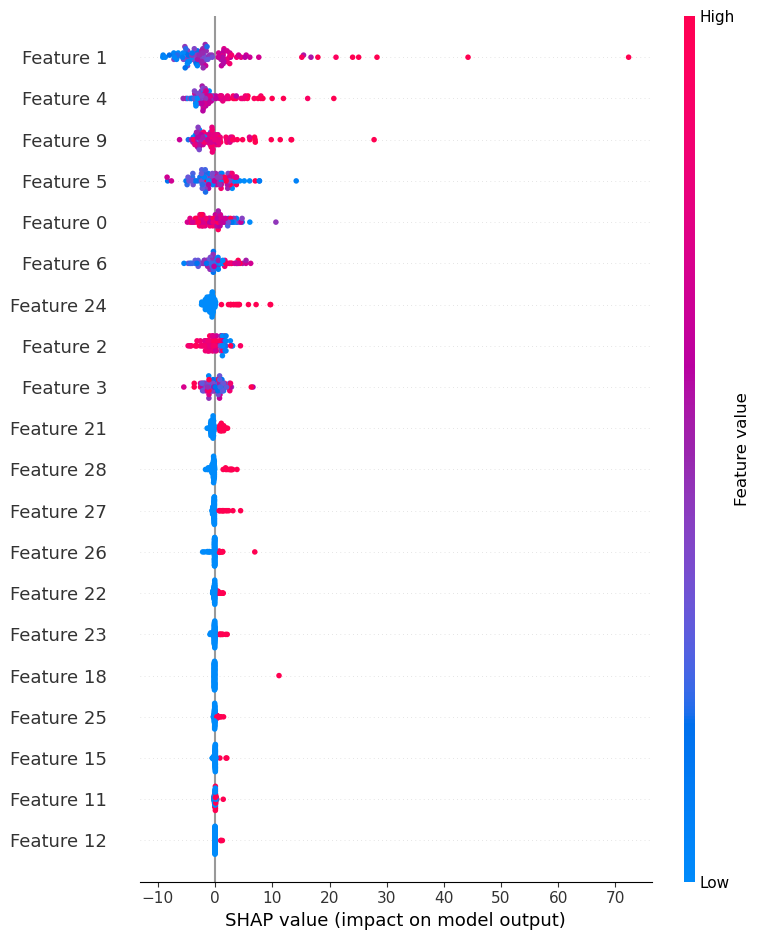

In [75]:
import shap

# Ensure X_test is fully transformed using the preprocessing pipeline
X_test_preprocessed = best_model.named_steps['preprocessing'].transform(X_test)

# Create SHAP explainer for the best-performing model
explainer = shap.Explainer(best_model.named_steps['regressor'], X_test_preprocessed)

# Select a specific observation from the test set (e.g., the first observation)
observation_idx = 0  # Index of the selected observation
observation = X_test_preprocessed[observation_idx].reshape(1, -1)  # Reshape to 2D array

# Compute SHAP values for the specific observation
shap_values = explainer.shap_values(observation, check_additivity=False)

# Display SHAP force plot for this observation
shap.force_plot(explainer.expected_value, shap_values[0], observation)

# Calculate SHAP values for the entire test set
shap_values_all = explainer.shap_values(X_test_preprocessed, check_additivity=False)

# Display SHAP summary plot for global feature importance
shap.summary_plot(shap_values_all, X_test_preprocessed)

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.